In [1]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import wandb

from tensorneat.algorithm.neat import NEAT
from tensorneat.algorithm.hyperneat import HyperNEAT, FullSubstrate
from tensorneat.genome import DefaultGenome
from tensorneat.genome.operations import DefaultMutation
from tensorneat.genome.gene import DefaultConn
from tensorneat.common import ACT

from pca_dim_mapping import PCAanalyzer 
from data_sampling import collect_random_policy_data, collect_expert_policy_data
from brax_env import CustomBraxEnv
from custom_pipeline import CustomPipeline
from hidden_layers import SubstrateGenerator
from manual_dim_mapping import ManualInputMapper


In [2]:

# change log
# manual mapping for ant | worse than without
# lower survival threshold, higher mutation rates | no significant improvement
# mutation rates changed back to lower values, additional hidden layers (2 to 4) with only one_double_hot (two_hot before), higher pop size | faster convergence, end result same
# lower survival threshold, more gens, species fitness mean (before max) | hardly any improvement in max fitness for 20 gen, then similiar with decreasing variance (nice convergence)



Tested [Brax environments](https://github.com/google/brax/tree/main/brax/envs):
* ant
* halfcheetah
* swimmer

In [3]:
ENV_NAME = "ant"
WANDB_NAME_SUFFIX = "auto"

ENV_BACKEND = "generalized"  # ['generalized', 'positional', 'spring']
MAX_STEP = 2000
FITNESS_TARGET = 5000.0

GENERATION_LIMIT = 100
POP_SIZE = 500
SPECIES_SIZE = 10

In [4]:
HIDDEN_LAYER_TYPE = "two_hot"        # ["shift" / "one_hot" / "two_hot" / "one_double_hot"], defaults to one_hot
HIDDEN_DEPTH = 2                            # >=1

REPEAT_TIMES = 5 
WEIGHT_TRESHOLD = 0.1

ALL_ENV_SPECIFIC_ARGS = {
    "ant": {
        "healthy_reward": 0.1,
        "ctrl_cost_weight": 0.1,
        "contact_cost_weight": 5e-4
    },
    "halfcheetah": {
        "forward_reward_weight": 2.0,
        "ctrl_cost_weight": 0.05
    },
    "swimmer": {
        "ctrl_cost_weight": 0.0001
    }
}

env_specific_args = ALL_ENV_SPECIFIC_ARGS.get(ENV_NAME, {})


expert_sample_config = {
    "generation_limit": 20,
    "pop_size": 1000,
    "species_size": 10,
    "hidden_depth": 1,
    "weight_threshold": WEIGHT_TRESHOLD,
    "fitness_target": FITNESS_TARGET,
    "env_args": env_specific_args
}


In [5]:
OUTPUT_DIR = f"output/{ENV_NAME}"
if not os.path.exists(f"output"):
    os.mkdir("output")
if not os.path.exists(f"{OUTPUT_DIR}"):
    os.mkdir(f"{OUTPUT_DIR}")

In [6]:
env_problem = CustomBraxEnv(
    env_name=ENV_NAME,
    backend=ENV_BACKEND,
    brax_args=env_specific_args,
    max_step=MAX_STEP,
    repeat_times=REPEAT_TIMES,
    obs_normalization=False,
    sample_episodes=16,
    )
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]

print("env_problem.input_shape: ", env_problem.input_shape)

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


env_problem.input_shape:  (27,)


In [7]:
SAMPLING_STEPS = 10000
key = jax.random.PRNGKey(123) # Use a new master key for this process

NUM_EXPERTS_TO_SAMPLE = 2  # The number of independent training runs
all_expert_data = []       # A list to store the data from each run

for i in range(NUM_EXPERTS_TO_SAMPLE):
    print(f"\nTraining and Sampling Expert #{i+1}/{NUM_EXPERTS_TO_SAMPLE}")

    # Generate a unique key for this specific training run to ensure independence
    key, subkey = jax.random.split(key)

    expert_data_run = collect_expert_policy_data(
        env_problem=env_problem,
        key=subkey,  # Use the unique subkey for this run
        num_steps=SAMPLING_STEPS,
        training_config=expert_sample_config
    )
    all_expert_data.append(expert_data_run)

# np.vstack stacks the arrays vertically (row-wise) to combine the data
combined_expert_data = np.vstack(all_expert_data)

print(f"\nData collection complete. Combined data from {NUM_EXPERTS_TO_SAMPLE} experts.")
print(f"Shape of each run's data: {all_expert_data[0].shape}")
print(f"Shape of combined expert data: {combined_expert_data.shape}")


# Method B: Collect random data
key, random_key = jax.random.split(key)
random_data = collect_random_policy_data(env_problem, random_key, SAMPLING_STEPS)


Training and Sampling Expert #1/2

--- Starting Expert Training and Data Collection ---
--> Step 1: Configuring and training the expert agent...
Qurey dimension for sampling:  4
initializing
initializing finished
start compile
compile finished, cost time: 25.679385s
Generation: 1, Cost time: 12649.85ms
 	fitness: valid cnt: 1000, max: 6.0602, min: -477.3800, mean: -66.2292, std: 80.3020

	node counts: max: 6, min: 5, mean: 5.26
 	conn counts: max: 6, min: 2, mean: 4.05
 	species: 10, [712, 2, 3, 1, 2, 1, 1, 1, 25, 252]

Generation: 2, Cost time: 12776.69ms
 	fitness: valid cnt: 1000, max: 11.3777, min: -460.5372, mean: -50.2545, std: 70.2574

	node counts: max: 7, min: 5, mean: 5.60
 	conn counts: max: 8, min: 1, mean: 4.14
 	species: 10, [295, 44, 86, 63, 32, 43, 35, 27, 10, 365]

Generation: 3, Cost time: 12688.96ms
 	fitness: valid cnt: 1000, max: 31.1679, min: -452.8799, mean: -43.1058, std: 66.0095

	node counts: max: 8, min: 5, mean: 5.82
 	conn counts: max: 9, min: 0, mean: 4.1

2025-09-02 22:46:04.550461: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-02 22:46:04.550477: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-02 22:46:04.550482: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-02 22:46:04.550486: W external/xla/xla/service/gpu/au

--- Expert Training and Data Collection Finished ---


Training and Sampling Expert #2/2

--- Starting Expert Training and Data Collection ---
--> Step 1: Configuring and training the expert agent...
Qurey dimension for sampling:  4
initializing
initializing finished
start compile
compile finished, cost time: 24.968346s
Generation: 1, Cost time: 12847.70ms
 	fitness: valid cnt: 1000, max: 9.5788, min: -423.9240, mean: -65.0812, std: 74.8354

	node counts: max: 6, min: 5, mean: 5.25
 	conn counts: max: 6, min: 2, mean: 4.07
 	species: 10, [440, 1, 225, 1, 3, 5, 2, 2, 55, 266]

Generation: 2, Cost time: 12557.41ms
 	fitness: valid cnt: 1000, max: 12.9729, min: -444.3475, mean: -45.2964, std: 63.1266

	node counts: max: 7, min: 5, mean: 5.46
 	conn counts: max: 7, min: 1, mean: 4.02
 	species: 10, [55, 105, 244, 100, 114, 41, 1, 1, 2, 337]

Generation: 3, Cost time: 12630.53ms
 	fitness: valid cnt: 1000, max: 10.0980, min: -551.0790, mean: -40.7783, std: 63.2465

	node counts: max: 8, min

In [ ]:

# --- Step 2: Analyze and visualize both datasets ---
VARIANCE_THRESHOLD = 0.70
MAX_PCA_DIMS = 9 # doesn not include additional dimension for layering direction

# --- Analysis A: PCA on Expert Data ---
print("\n--- Analyzing Expert Data ---")
analyzer_expert = PCAanalyzer(
    data=combined_expert_data, obs_size=obs_size, act_size=act_size,
    variance_threshold=VARIANCE_THRESHOLD, max_dims=MAX_PCA_DIMS
)
input_coors_exp, output_coors_exp, coord_size_exp = analyzer_expert.generate_io_coordinates()
analyzer_expert.plot_variance(save_path=f"{OUTPUT_DIR}/pca_variance_expert.png")

# --- Analysis B: PCA on Random Data ---
print("\n--- Analyzing Random Data ---")
analyzer_random = PCAanalyzer(
    data=random_data, obs_size=obs_size, act_size=act_size,
    variance_threshold=VARIANCE_THRESHOLD, max_dims=MAX_PCA_DIMS
)
input_coors_rand, output_coors_rand, coord_size_rand = analyzer_random.generate_io_coordinates()
analyzer_random.plot_variance(save_path=f"{OUTPUT_DIR}/pca_variance_random.png")

# Manual dimensional mapping
print("--- Manual mapping ---")
manual_mapper = ManualInputMapper(
    env_name=ENV_NAME,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=HIDDEN_LAYER_TYPE,
    hidden_depth=HIDDEN_DEPTH,
)
input_coors_manual, coord_size_manual = manual_mapper.get_input_coors()
output_coors_manual = manual_mapper.get_output_coors(coord_size_manual)

print("\n--- Comparison Finished ---")
print(f"Dimensions from expert data: {coord_size_exp}")
print(f"Dimensions from random data: {coord_size_rand}")
print(f"Dimensions from manual mapping: {coord_size_manual}")


--- Analyzing Expert Data ---
Running PCA to find feature dimensions covering 70.0% of variance (with a hard limit of 9 dimensions)...
PCA found 3 dimensions needed for 70.0% variance.
Applying max limit. Final number of feature dimensions: 3
Added layering dimension. Final coordinate size: 4
PCA variance plot saved to: output/ant/pca_variance_expert.png

--- Analyzing Random Data ---
Running PCA to find feature dimensions covering 70.0% of variance (with a hard limit of 9 dimensions)...
PCA found 21 dimensions needed for 70.0% variance.
Applying max limit. Final number of feature dimensions: 9
Added layering dimension. Final coordinate size: 10
PCA variance plot saved to: output/ant/pca_variance_random.png

--- Comparison Finished ---
Dimensions from expert data: 4
Dimensions from random data: 10


In [9]:
print("Generating hidden coordinates for the 'expert' substrate...")

# (You might need to re-instantiate this if it's not in the same cell)
substrate_gen = SubstrateGenerator(
    env_name=ENV_NAME,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=HIDDEN_LAYER_TYPE,
    hidden_depth=HIDDEN_DEPTH,
)

bias_coordinate = tuple([0.0] * coord_size_exp)
input_coors_exp.append(bias_coordinate)

hidden_coors_exp = substrate_gen.get_hidden_coors(
    input_coors=input_coors_exp, 
    coord_size=coord_size_exp
)


Generating hidden coordinates for the 'expert' substrate...


In [10]:
input_coors = input_coors_exp
hidden_coors = hidden_coors_exp
output_coors = output_coors_exp

print(f"Number of input nodes (incl. bias): {len(input_coors)}")
print("List of input nodes: ", input_coors)
print(f"Number of hidden nodes: {len(hidden_coors)}")
print(f"Number of output nodes: {len(output_coors)}")

# 2. Now, create the substrate with the correct variables in the correct places.
print("Creating the FullSubstrate...")
active_substrate = FullSubstrate(
    input_coors=input_coors,      # Coordinates for input layer
    hidden_coors=hidden_coors,    # Correctly use the newly generated hidden coordinates
    output_coors=output_coors     # Correctly use the output coordinates list, not the size integer
)

print("Substrate created successfully.")

Number of input nodes (incl. bias): 28
List of input nodes:  [(-0.004373261239379644, 0.3244849741458893, -0.047538626939058304, 0.0), (-0.0031172321178019047, 0.23755811154842377, -0.015880761668086052, 0.0), (0.006430181674659252, 0.005284449551254511, 0.47622454166412354, 0.0), (0.002070851856842637, -0.2948523759841919, -0.2075406014919281, 0.0), (0.004385981243103743, -0.29843074083328247, 0.057097870856523514, 0.0), (-0.0030522416345775127, 0.3230172097682953, 0.07096719741821289, 0.0), (-0.002896408550441265, 0.3226431608200073, 0.10090138018131256, 0.0), (-0.0033284288365393877, 0.32383203506469727, 0.09391136467456818, 0.0), (0.0010734788374975324, -0.13164585828781128, 0.35623130202293396, 0.0), (-0.013717354275286198, 0.22691766917705536, -0.3329468369483948, 0.0), (0.0040344116277992725, -0.13197320699691772, 0.4421042799949646, 0.0), (0.005248683504760265, 0.16644109785556793, 0.3323894441127777, 0.0), (-0.0028919691685587168, 0.32715433835983276, 0.05767812952399254, 0.0)

In [11]:
print("query_coors shape:", active_substrate.query_coors.shape)  # (num_queries, query_dim)
query_dim = int(active_substrate.query_coors.shape[1])
print(f"That means {int(query_dim/2)} dimensions with 2 query nodes each.")


query_coors shape: (576, 8)
That means 4 dimensions with 2 query nodes each.


In [12]:
conn_gene = DefaultConn(
    weight_mutate_power=0.25,
    weight_mutate_rate=0.3,
    weight_lower_bound=-1.0,
    weight_upper_bound=1.0,
)

genome=DefaultGenome(
    num_inputs=query_dim,
    num_outputs=1,
    output_transform=ACT.tanh,
    max_nodes=256,
    max_conns=1024,
    init_hidden_layers=[int(query_dim/4)],
    mutation=DefaultMutation(
        node_add=0.4,
        conn_add=0.5, 
        node_delete=0.15,
        conn_delete=0.2,
    ),
    conn_gene=conn_gene,
)

neat_algorithm = NEAT(
    pop_size=POP_SIZE,
    species_size=SPECIES_SIZE,
    survival_threshold=0.10,
    compatibility_threshold=1.0,
    species_fitness_func=jnp.max, # alternative jnp.mean / jnp.max,
    genome_elitism=5,
    species_elitism=3,
    genome=genome,
)

evol_algorithm = HyperNEAT(
    substrate=active_substrate,
    neat=neat_algorithm,
    activation=ACT.tanh,
    activate_time=25, # How many internal activation steps per simulation step (recurrence)
    output_transform=ACT.tanh,
    weight_threshold=WEIGHT_TRESHOLD,
)

In [13]:
print("Total observation shape:", env_problem.input_shape)
print("Total action shape:", env_problem.output_shape)

print("Substrate input dimension:", active_substrate.query_coors.shape[1])
print("Algorithm input dimension:", evol_algorithm.num_inputs)

Total observation shape: (27,)
Total action shape: (8,)
Substrate input dimension: 8
Algorithm input dimension: 27


In [14]:
wanbd_name = f"{ENV_NAME}_{WANDB_NAME_SUFFIX}" if WANDB_NAME_SUFFIX != "" else ENV_NAME
WANDB_TAGS = [HIDDEN_LAYER_TYPE, ENV_NAME]

wandb.init(name=wanbd_name, project="connection_cost", tags=WANDB_TAGS)

wandb: Currently logged in as: wirkelzirkel (wirkelzirkel-iu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
pipeline = CustomPipeline(
    algorithm=evol_algorithm,
    problem=env_problem,
    seed=42,
    generation_limit=GENERATION_LIMIT,
    fitness_target=FITNESS_TARGET,
    is_save=False,
    save_dir=OUTPUT_DIR,
)

In [16]:
init_state = pipeline.setup()
state = pipeline.auto_run(
    state=init_state
)

print(f"\nTraining finished. Best fitness achieved: {pipeline.best_fitness}")

wandb.finish()

initializing
initializing finished
start compile
compile finished, cost time: 21.413810s
Generation: 1, Cost time: 7408.21ms
 	fitness: valid cnt: 500, max: 19.8633, min: -323.2246, mean: -67.1715, std: 46.5107

	node counts: max: 12, min: 10, mean: 11.27
 	conn counts: max: 20, min: 8, mean: 17.17
 	species: 10, [296, 16, 1, 8, 75, 8, 1, 12, 27, 56]

Generation: 2, Cost time: 7398.78ms
 	fitness: valid cnt: 500, max: 74.8325, min: -357.3440, mean: -61.2680, std: 54.2974

	node counts: max: 13, min: 9, mean: 11.31
 	conn counts: max: 22, min: 0, mean: 15.81
 	species: 10, [38, 108, 93, 36, 43, 64, 17, 11, 8, 82]

Generation: 3, Cost time: 7407.65ms
 	fitness: valid cnt: 500, max: 90.6633, min: -317.1474, mean: -44.7687, std: 56.6425

	node counts: max: 14, min: 9, mean: 11.44
 	conn counts: max: 22, min: 0, mean: 15.28
 	species: 10, [14, 84, 49, 44, 62, 23, 45, 21, 8, 150]

Generation: 4, Cost time: 7415.15ms
 	fitness: valid cnt: 500, max: 109.1227, min: -320.1558, mean: -39.5701, st

fitness_max,▁▂▃▃▄▅▅▅▅▇▆▆▆▆▆▇▆▇▇▇▇▇██▇█▇█▇███████████
fitness_mean,▁▃▅▅▇▆▇▆▇▇▇█▇█▇▇▇▇▇█▇▇▇███▇▆█▇▇▇▇▇▇▇▇███
fitness_min,▆▇▇▅▆▆▆▆█▄▅▆▆▄▂▇▅▂█▆▅▅▂▅▄▁▄▄▆▅▄▃▆▇▄▆▄▇▅▄
fitness_std,▁▃▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▇▇▇▆▆▇▇▆▇▆▆▇▆▇▆▆▆▇▆▇▇█
generation,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
fitness_max,318.52707
fitness_mean,19.34175
fitness_min,-462.96997
fitness_std,103.90693
generation,100


In [17]:
state_for_show = state[0] if isinstance(state, tuple) else state

# Transform the best genome into network parameters
best_genome = pipeline.best_genome

# Use the built-in show method to visualize and save video
pipeline.show(
    state=state_for_show,
    best=best_genome,
    output_type="mp4",
    save_path=f"{OUTPUT_DIR}/agent.mp4",
)


Total reward:  304.85077


/home/andi/anaconda3/envs/jax/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


mp4 saved to:  output/ant/agent.mp4


In [18]:
# visualize cppn
cppn_genome = pipeline.algorithm.neat.genome
cppn_network = cppn_genome.network_dict(state, *best_genome)
cppn_genome.visualize(cppn_network, save_path=f"{OUTPUT_DIR}/cppn_network.svg")

Manually reconstructing the phenotype. A visual layout will be generated.
Substrate has 576 potential connections.
Visualizing 198 connections. Excluded loops. Weight threshold: 0.1


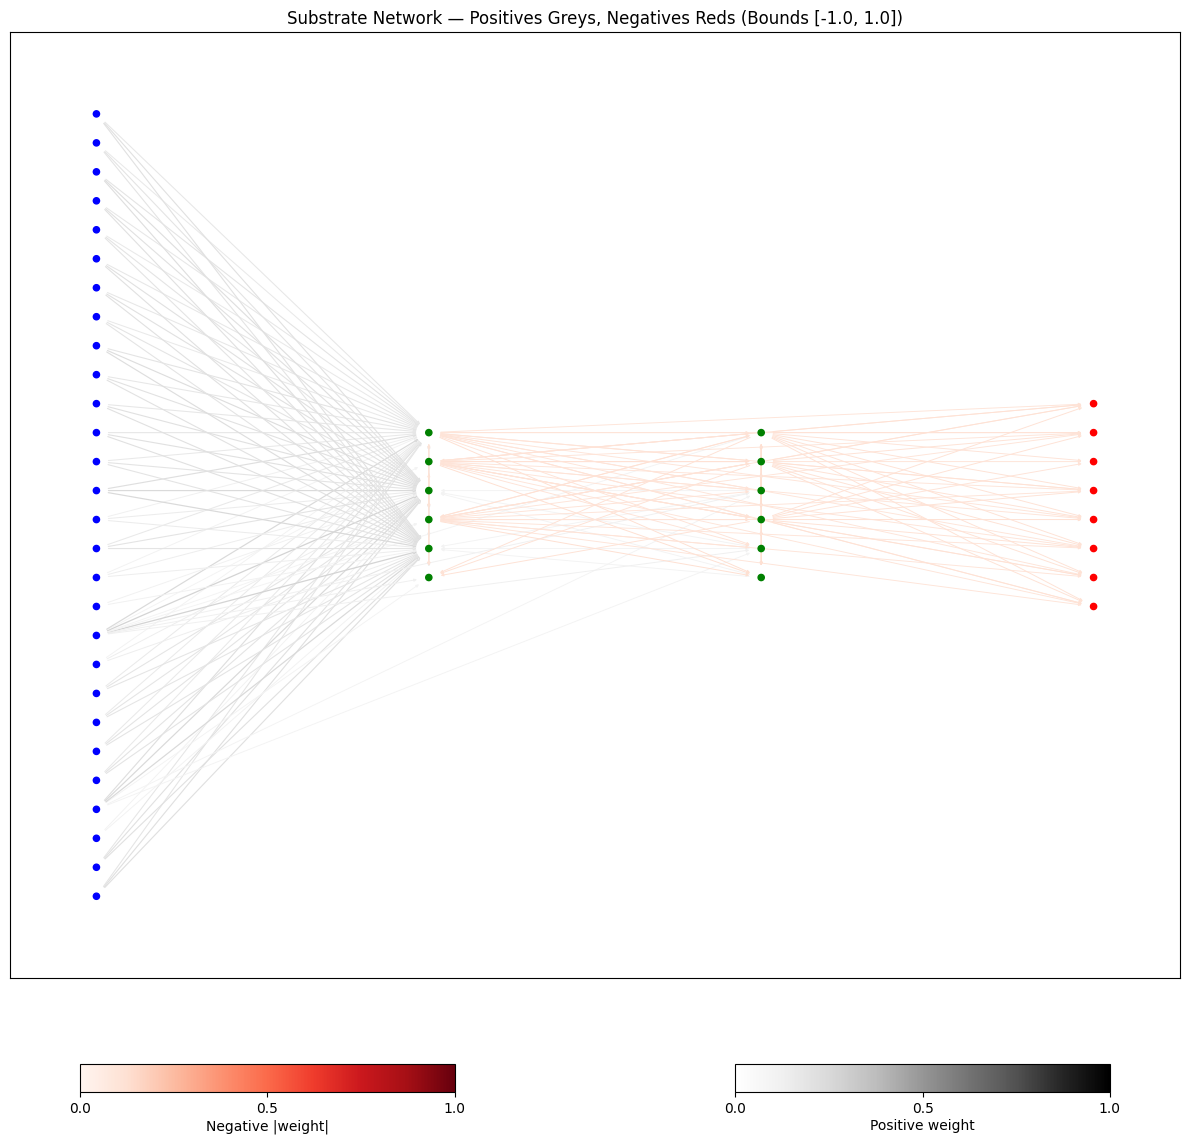

Visualization saved to: output/ant/ANN.svg


In [20]:
import networkx as nx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

print("Manually reconstructing the phenotype. A visual layout will be generated.")

# 1) Weights from CPPN (your existing logic)
neat_algorithm = pipeline.algorithm.neat
cppn_params = neat_algorithm.transform(state, best_genome)
query_coors = active_substrate.query_coors
cppn_forward_func = neat_algorithm.forward

all_substrate_weights = jax.vmap(
    cppn_forward_func, in_axes=(None, None, 0)
)(state, cppn_params, query_coors)

all_substrate_connections = np.array(active_substrate.conns)
all_substrate_weights_np = np.array(all_substrate_weights).squeeze()

# 2) Select edges: no percentile pruning; keep internal threshold (toggleable)
internal_weight_threshold = pipeline.algorithm.weight_threshold
active_mask = np.abs(all_substrate_weights_np) > internal_weight_threshold
active_conns = all_substrate_connections[active_mask]
active_weights = all_substrate_weights_np[active_mask]

# If you want literally every potential connection regardless of threshold:
# active_conns = all_substrate_connections
# active_weights = all_substrate_weights_np

print(f"Substrate has {len(all_substrate_connections)} potential connections.")

# Build graph, assign layers, generate layout
G_to_draw = nx.DiGraph()
all_node_keys = [int(n[0]) for n in active_substrate.nodes]


# Which coordinate dimension encodes "layer"? In your code it's the last one.
LAYER_AXIS = -1  # last coordinate

def compute_hidden_layer_groups(hidden_coors, layer_axis=LAYER_AXIS):
    """
    Returns:
    order_vals: sorted unique layer values (e.g., 3, 6, 9, ...)
    idx_groups: list of lists; each inner list has indices of hidden nodes that belong to that layer
    widths:     number of hidden nodes per layer (len of each group)
    """
    hc = np.asarray(hidden_coors)
    if hc.ndim != 2:
        raise ValueError(f"hidden_coors must be 2D (num_hidden, coord_dims); got shape {hc.shape}")

    layer_vals = hc[:, layer_axis]
    order_vals = np.unique(layer_vals)
    idx_groups = [np.where(layer_vals == v)[0].tolist() for v in order_vals]
    widths = [len(g) for g in idx_groups]
    return order_vals.tolist(), idx_groups, widths

# Example usage:
order_vals, hidden_idx_groups, hidden_widths = compute_hidden_layer_groups(hidden_coors, layer_axis=LAYER_AXIS)
# All node keys in substrate order (N,1) -> flatten to ints
all_node_keys = [int(n[0]) for n in active_substrate.nodes]

num_inputs  = len(input_coors)
num_outputs = len(output_coors)
num_hiddens = len(hidden_coors)

# Correct slicing for FullSubstrate:
input_keys  = all_node_keys[:num_inputs]
output_keys = all_node_keys[num_inputs : num_inputs + num_outputs]
hidden_keys = all_node_keys[num_inputs + num_outputs : num_inputs + num_outputs + num_hiddens]

# Add nodes to the graph with subsets (partitions) for visualization
G_to_draw = nx.DiGraph()

# Inputs at layer 0
for k in input_keys:
    G_to_draw.add_node(k, subset=0)

# Hidden layers (1..HIDDEN_DEPTH) — we map the *contiguous* hidden range to layers
start_hidden = num_inputs + num_outputs

# If each hidden layer has the same width (classic case):
# hidden_width_full = len(input_coors)  # or len(hidden_coors)//HIDDEN_DEPTH
# But we will use the robust per-layer widths we computed above:
cum = 0
for j, w in enumerate(hidden_widths):
    layer_id = j + 1
    start = start_hidden + cum
    end   = start + w
    for i in range(start, min(end, len(all_node_keys))):
        G_to_draw.add_node(all_node_keys[i], subset=layer_id)
    cum += w

# Outputs at the final layer (after all hidden layers)
output_layer_id = HIDDEN_DEPTH + 1
for k in output_keys:
    G_to_draw.add_node(k, subset=output_layer_id)


# Layout from the detailed layer assignment
pos = nx.multipartite_layout(G_to_draw, subset_key='subset')

# 4) Fixed-bounds grayscale mapping & robust edge extraction

# Helper: coerce bounds to floats (in case 0,0 was typed instead of 0.0)
def _to_float_bound(x, name):
    if isinstance(x, (tuple, list, np.ndarray)):
        if len(x) == 0:
            raise ValueError(f"{name} is empty; set a valid float (e.g., 0.0).")
        x = x[0]
    try:
        return float(x)
    except Exception as e:
        raise ValueError(
            f"Could not convert {name}={x!r} to float. "
            f"Use a scalar like 0.0 or 1.0. Original error: {e}"
        )

LOWER = _to_float_bound(-1, "WEIGHT_LOWER_BOUND")
UPPER = _to_float_bound(1, "WEIGHT_UPPER_BOUND")

# Your active_conns rows look like [src, dst, extra]; take first two columns
ac = np.asarray(active_conns)
if ac.ndim != 2 or ac.shape[1] < 2:
    raise ValueError(f"Expected active_conns to have at least 2 columns; got shape {ac.shape}")

all_edges = [(int(row[0]), int(row[1])) for row in ac]
all_weights = np.asarray(active_weights)

# NEW: Filter out self-loops
# Create lists to hold the edges and weights that are NOT self-loops
edges_to_add = []
active_weights_filtered = []
for edge, weight in zip(all_edges, all_weights):
    if edge[0] != edge[1]:  # This condition checks if the edge is NOT a self-loop
        edges_to_add.append(edge)
        active_weights_filtered.append(weight)

# Convert back to a NumPy array for consistency
active_weights = np.array(active_weights_filtered)

print(f"Visualizing {len(active_weights)} connections. Excluded loops. Weight threshold: {internal_weight_threshold}")

# Add edges to graph
G_to_draw.add_edges_from(edges_to_add)

# Magnitudes for color mapping (must align 1:1 with edges_to_add)
abs_w = np.abs(active_weights)
if len(abs_w) != len(edges_to_add):
    raise ValueError(
        f"Edge/weight mismatch: {len(edges_to_add)} edges vs {len(abs_w)} weights. "
        "Ensure any filtering is applied identically to connections and weights."
    )

# Edge-width scaling (optional) using fixed bounds in [0,1]
if abs_w.size > 0:
    norm_for_widths = np.clip((abs_w - LOWER) / (UPPER - LOWER), 0.0, 1.0)
else:
    norm_for_widths = np.array([], dtype=float)

# Node colors: inputs=blue, outputs=red, hidden=green
node_colors = []
for node_key in G_to_draw.nodes():
    if node_key in input_keys:
        color = 'blue'
    elif node_key in output_keys:
        color = 'red'
    else:
        color = 'green'
    node_colors.append(color)

# 5) Draw with separate colormaps for positive (Greys) and negative (Reds)

fig, ax = plt.subplots(figsize=(12, 12))

weights = np.asarray(active_weights)
idx_all = np.arange(len(edges_to_add))

pos_idx = idx_all[weights > 0]
neg_idx = idx_all[weights < 0]
zero_idx = idx_all[weights == 0]  # optional

edges_pos = [edges_to_add[i] for i in pos_idx]
edges_neg = [edges_to_add[i] for i in neg_idx]
w_pos = weights[pos_idx]                # > 0
w_neg_mag = -weights[neg_idx]           # positive magnitudes for negative edges

# Edge widths scaled per side using fixed bounds
eps = np.finfo(float).eps  # protect against division by zero

widths_pos = 0.5 + 1.5 * np.clip(w_pos / max(UPPER, eps), 0.0, 1.0) if len(w_pos) else []
widths_neg = 0.5 + 1.5 * np.clip(w_neg_mag / max(-LOWER, eps), 0.0, 1.0) if len(w_neg_mag) else []

# Draw nodes once
nx.draw_networkx_nodes(
    G_to_draw,
    pos=pos,
    node_color=node_colors,
    node_size=20,
    ax=ax
)

# Draw POSITIVE edges: Greys (white → black), mapped over [0, UPPER]
if len(edges_pos):
    nx.draw_networkx_edges(
        G_to_draw,
        pos=pos,
        edgelist=edges_pos,
        edge_color=w_pos,             # raw positive weights
        edge_cmap=plt.cm.Greys,
        edge_vmin=0.0,
        edge_vmax=float(UPPER),
        width=widths_pos,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=4,
        ax=ax
    )

# Draw NEGATIVE edges: Reds (white → red), mapped over [0, |LOWER|] using magnitudes
if len(edges_neg):
    nx.draw_networkx_edges(
        G_to_draw,
        pos=pos,
        edgelist=edges_neg,
        edge_color=w_neg_mag,         # magnitudes of negative weights
        edge_cmap=plt.cm.Reds,
        edge_vmin=0.0,
        edge_vmax=float(-LOWER),
        width=widths_neg,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=4,
        ax=ax
    )

# Colorbars
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ax.set_title(f"Substrate Network — Positives Greys, Negatives Reds (Bounds [{LOWER}, {UPPER}])")
fig.tight_layout()
fig.subplots_adjust(bottom=0.18) # Manually make space at the bottom for colorbars

# Left: negative (Reds)
if len(w_neg_mag):
    sm_neg = ScalarMappable(cmap=plt.cm.Reds,
                            norm=Normalize(vmin=0.0, vmax=float(-LOWER)))
    sm_neg.set_array([])
    cax_neg = inset_axes(
        ax, width="32%", height="3%", loc="lower left",
        bbox_to_anchor=(0.06, -0.12, 1.0, 1.0),  # left aligned
        bbox_transform=ax.transAxes, borderpad=0
    )
    cbar_neg = fig.colorbar(sm_neg, cax=cax_neg, orientation='horizontal')
    cbar_neg.set_label('Negative |weight|', labelpad=2)
    cbar_neg.ax.xaxis.set_label_position('bottom')
    cbar_neg.ax.xaxis.set_ticks_position('bottom')
    cbar_neg.set_ticks([0, (-LOWER)/2, -LOWER])

# Right: positive (Greys)
if len(w_pos):
    sm_pos = ScalarMappable(cmap=plt.cm.Greys,
                            norm=Normalize(vmin=0.0, vmax=float(UPPER)))
    sm_pos.set_array([])
    cax_pos = inset_axes(
        ax, width="32%", height="3%", loc="lower right",
        bbox_to_anchor=(-0.06, -0.12, 1.0, 1.0),  # right aligned
        bbox_transform=ax.transAxes, borderpad=0
    )
    cbar_pos = fig.colorbar(sm_pos, cax=cax_pos, orientation='horizontal')
    cbar_pos.set_label('Positive weight', labelpad=2)
    cbar_pos.ax.xaxis.set_label_position('bottom')
    cbar_pos.ax.xaxis.set_ticks_position('bottom')
    cbar_pos.set_ticks([0, UPPER/2, UPPER])

out_path = f"{OUTPUT_DIR}/ANN.svg"
fig.savefig(out_path, dpi=800)
plt.show()
plt.close(fig)

print(f"Visualization saved to: {out_path}")

In [ ]:
import pickle
import jax.tree_util as tree_util

# SAVING THE BEST GENOME

# The best_genome is a JAX PyTree living on the GPU/TPU.
# For safe saving, we first pull it to the CPU and convert it to NumPy arrays.
best_genome_numpy = tree_util.tree_map(jax.device_get, best_genome)

# Define the filename
save_filename = f"{OUTPUT_DIR}/best_genome.pkl"

# Use pickle to serialize and save the NumPy version of the genome
with open(save_filename, "wb") as f:
    pickle.dump(best_genome_numpy, f)

print(f"Best genome saved successfully to: {save_filename}")